# Introduction

The following example shows the usage of the mcoo package. mcoo allows running monte carlo simulations in an easy and model independent way. Basically, the package provides tools to check for result convergence and to perform a sensitivity analysis.

In this example, we will look at the prospects of a potential geothermal well that produces heat for a district heating network (look, I am a simple guy, that's all I know...). It is an overly simplified example of course, so please do not laugh at the naivity of some assumptions.

The model goes something like this:

The underlying geological parameters are uncertain, but not unknown. Thanks to existing wells we are able to define probability density functions for these parameters. The parameters are:

- flow rate when maintaining the dynamic water level at a specific depth
- reservoir temperature gradient
- depth of top reservoir

Then there are some model parameters which are not geologically uncertain but refer to the design of the technical equipment. While some of them could also be calculated deterministically, let's just say the project is at an early stage and we don't want to put too much effort in it already. These parameters are:

- injection temperature
- efficiency of the submersible pump

Last, we are interested in the econmics of the project. For this, we are using these parameters:

- selling price of the produced heat
- buying price for electrical power

First, let's set up our model parameters as introduced above. For some parameters, there is historical data available to which we can fit our pdf. For others, we have to rely on expert assessment.

# Setup

In [1]:
#As a first step, we need some imports (inlcuding the mcoo module)
import sys
sys.path.append('../PyMoCa')
import PyMoCa as mc, scipy.stats as stats, numpy as np, pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#create a new simulation with 10.000 realisations and set a directory where results are saved
nmc = 10000
mysim = mc.Simulation('geothermal', nmc = nmc, saveplots = False)
#mysim.set_savedir('/Users/mischasch/Documents/python projects/mcoo demo')

# Set up model parameters

Prepare the input parameters for the simulation.

## Geological parameters

In [3]:
#flow rate at a specific dynamic water level (expert judgement) [l/s]
par_q = mc.Param('q', stats.triang(1, loc = 60, scale = 40))


#reservoir temperature gradient [K/100 m]. Here there is some existing data we can fit on.
d_rtg = pd.read_csv('testrtg.txt', sep = '\t')
rtg = d_rtg.loc[:,['RTG_TR']].sort_values(by = 'RTG_TR').to_numpy().flatten()
fitparams = stats.triang.fit(rtg)

fit_RTG = stats.triang(fitparams[0], fitparams[1], fitparams[2])

par_RTG = mc.Param('RTG', fit_RTG, hist_data = rtg, unit = '°C/100 m')

#depth of top reservoir [m TVD]
par_tr = mc.Param('Top Reservoir', stats.uniform(loc = 2000, scale = 1000), unit = 'm TVD')

#ESP Förderhöhe [bara]
esp_fh = mc.Param('ESP head', stats.norm(50, 10), unit = '-')

#add the paramers to the simulation
mysim.addParameter(par_q)
mysim.addParameter(par_RTG)
mysim.addParameter(par_tr)
mysim.addParameter(esp_fh)

## Adding parameters: a closer look

In [4]:
#i can not add a new parameter this way
#mysim['new parameter'] = mc.Param('new parameter', stats.norm(50, 10))

In [5]:
#An elements name must be unique
#mysim.addParameter(mc.Param('new parameter', stats.norm(50, 10)))

In [6]:
#mysim.addResult(mc.Result('new parameter', s = np.ones(nmc)))

## Operational parameters

In [7]:
#reinjection temperature [°C]
par_Tr = mc.Param('TInj', stats.uniform(loc = 40, scale = 20), unit = '°C')

#efficiency of submersible pump [-]
par_nEsp = mc.Param('nEsp', stats.norm(loc = 0.7, scale = 0.2))

#add the parameters to the simulation
mysim.addParameter(par_Tr)
mysim.addParameter(par_nEsp)

## Parameter overview

Realising parameter sets wtih 10000 values


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,°C,50.00,5.77,40.00,60.00,58.00,50.00,42.00
sim,"10,000.00",°C,50.05,5.81,40.00,59.99,58.07,50.02,42.02


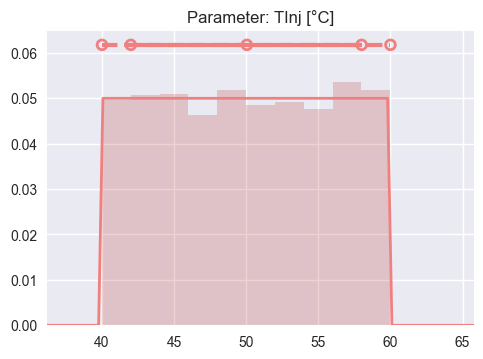

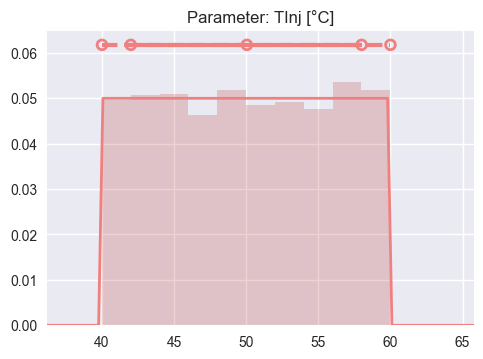

In [8]:
#to run the simulation, we first have to realise our parameter sets.
mysim.realiseParameterSets()

#i can now display a summary table or plot for each parameter
display(mysim['TInj'].summary)
mysim['TInj'].plot()

,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,triang,-,86.67,9.43,60.00,100.00,97.95,88.28,72.65
sim,"10,000.00",-,86.69,9.52,60.23,100.00,97.99,88.41,72.39


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,triang,°C/100 m,36.80,4.08,26.29,46.17,42.13,37.06,31.11
data,37.00,°C/100 m,37.12,3.31,27.02,45.43,40.85,36.90,33.81
sim,"10,000.00",°C/100 m,36.76,4.10,26.34,46.09,42.11,37.03,30.98


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,m TVD,"2,500.00",288.68,"2,000.00","3,000.00","2,900.00","2,500.00","2,100.00"
sim,"10,000.00",m TVD,"2,494.63",290.35,"2,000.04","2,999.71","2,901.86","2,489.76","2,096.30"


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,norm,-,50.00,10.00,-inf,inf,62.82,50.00,37.18
sim,"10,000.00",-,49.84,10.01,8.73,90.72,62.46,49.81,37.00


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,uniform,°C,50.00,5.77,40.00,60.00,58.00,50.00,42.00
sim,"10,000.00",°C,50.05,5.81,40.00,59.99,58.07,50.02,42.02


,n / fit,unit,mean,std,min,max,P10,P50,P90
fit,norm,-,0.70,0.20,-inf,inf,0.96,0.70,0.44
sim,"10,000.00",-,0.70,0.20,-0.01,1.49,0.96,0.70,0.44


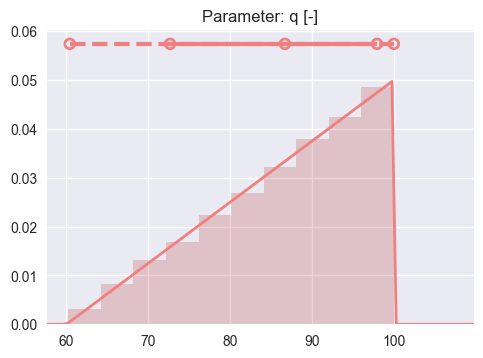

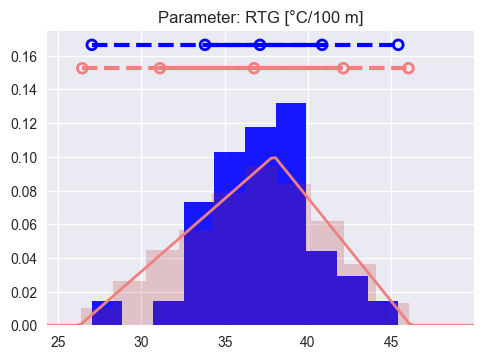

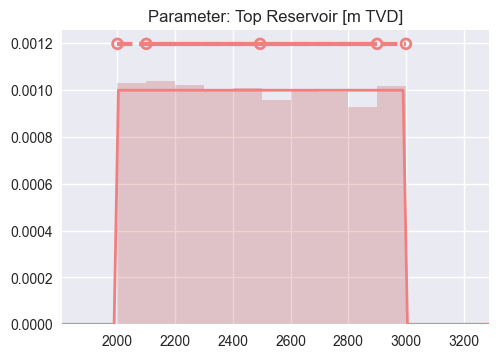

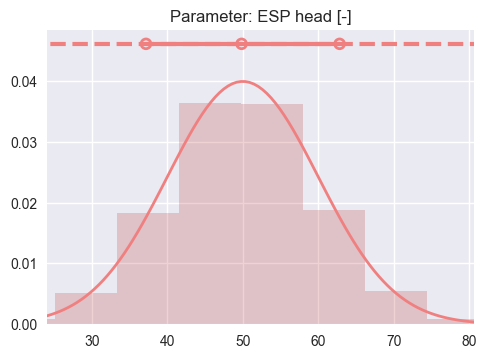

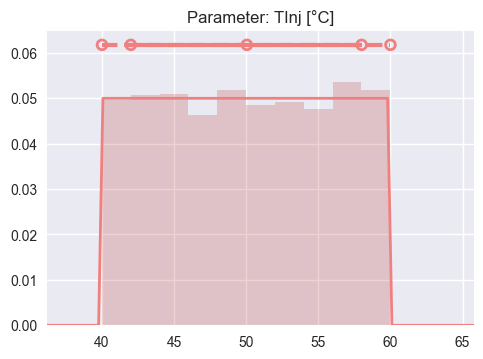

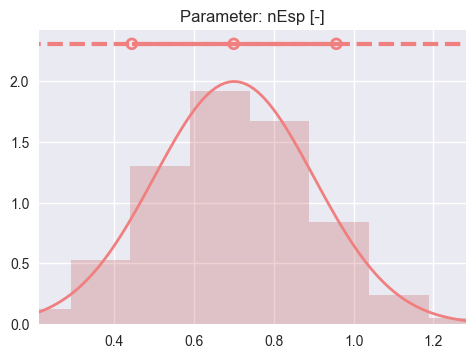

In [9]:
mysim.showParameters()

# Run the simulation

In [10]:
#When running the simulation, it helps having an overview of all the parameters and results 
#that are already in there.

mysim.summary

,type,mean,std,min,max,P90,P50,P10
name,,,,,,,,
q,parameter,86.69,9.52,60.23,100.00,72.39,88.41,97.99
RTG,parameter,36.76,4.10,26.34,46.09,30.98,37.03,42.11
Top Reservoir,parameter,"2,494.63",290.35,"2,000.04","2,999.71","2,096.30","2,489.76","2,901.86"
ESP head,parameter,49.84,10.01,8.73,90.72,37.00,49.81,62.46
TInj,parameter,50.05,5.81,40.00,59.99,42.02,50.02,58.07
nEsp,parameter,0.70,0.20,-0.01,1.49,0.44,0.70,0.96


In [11]:
#now, we can access all realised parameter sets with the param.s attribute.
#Using these sets, the actual simulation results are calculated

#compute production temperature
res_Tp = 8 + mysim['RTG'].s * mysim['Top Reservoir'].s / 1000

#compute the heat than is produced (in MWth)
res_heat = mysim['q'].s /1000 *1000 * (res_Tp - mysim['TInj'].s) * 4.18e3 / 1e6

#compute ESP energy intake
res_ESP_intake = mysim['ESP head'].s * 1e5 * mysim['q'].s / 1000

#compute COP
cop = res_heat / res_ESP_intake

#add all computed results to the simulation
mysim.addResult(mc.Result('Production Temperature', res_Tp, unit = '°C'))
mysim.addResult(mc.Result('Thermal power', res_heat, unit = 'MWth'))
mysim.addResult(mc.Result('ESP intake (MW)', res_ESP_intake, unit = 'MWth'))
mysim.addResult(mc.Result('COP', cop, unit = '-'))

In [12]:
#I noticed an error and want to change a result. I can easily do that by accessing the .s attribute of any parameter or result.
mysim['ESP head'].s = mysim['q'].s / 1e6 #convert to MW

Before we check the results, let's make sure that we've chosen the number of realisation high enough for the results to be reliable:

Evaluating results
Parameter: Production Temperature ... Standard Error of the mean after the last iteration is 0.15 or 0.15 %%
Parameter: Thermal power ... Standard Error of the mean after the last iteration is 0.06 or 0.34 %%
Parameter: ESP intake (MW) ... Standard Error of the mean after the last iteration is 987.51 or 0.23 %%
Parameter: COP ... Standard Error of the mean after the last iteration is 0.00 or 0.41 %%


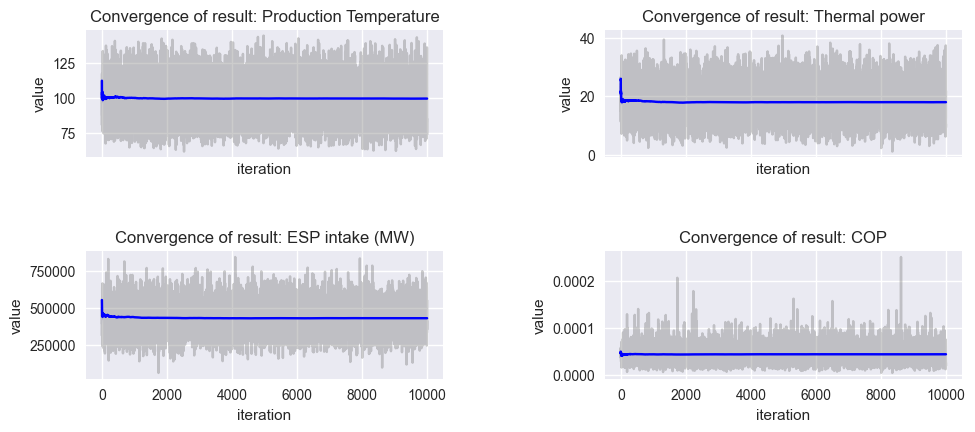

In [13]:
mysim.convergence()

#looks pretty good, no higher number of realisations seems required.

# Look at the results

,n,unit,mean,std,min,max,P90,P50,P10
result,10000,MWth,17.99,6.11,1.04,40.83,10.31,17.64,26.31


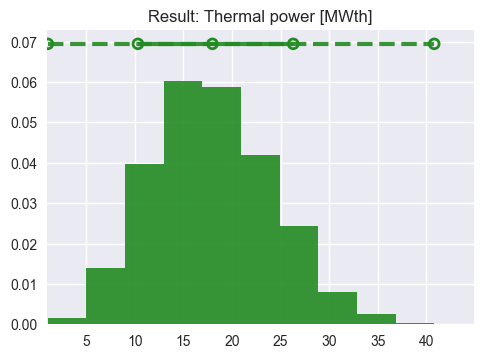

In [14]:
#again, I can either inspect a result individually...
display(mysim['Thermal power'].summary)
mysim['Thermal power'].plot()

In [15]:
#...or all at once

In [16]:
#mysim.showResults()

In [17]:
#then, how about a nice summary of all parameters and results
display(mysim.summary)

,type,mean,std,min,max,P90,P50,P10
name,,,,,,,,
q,parameter,86.69,9.52,60.23,100.00,72.39,88.41,97.99
RTG,parameter,36.76,4.10,26.34,46.09,30.98,37.03,42.11
Top Reservoir,parameter,"2,494.63",290.35,"2,000.04","2,999.71","2,096.30","2,489.76","2,901.86"
ESP head,parameter,0.00,0.00,0.00,0.00,0.00,0.00,0.00
TInj,parameter,50.05,5.81,40.00,59.99,42.02,50.02,58.07
nEsp,parameter,0.70,0.20,-0.01,1.49,0.44,0.70,0.96
Production Temperature,result,99.71,14.82,61.86,144.72,80.82,98.93,119.76
Thermal power,result,17.99,6.11,1.04,40.83,10.31,17.64,26.31
ESP intake (MW),result,"431,847.94","98,746.51","64,496.52","842,730.77","305,168.19","429,236.60","559,221.32"


# Sensitivity analysis

So far, so good. Off for a beer now... right?
Well, what If I told you that the real work is just about to start? That what we did until here was the easy part? I know...

So: Sensitivity analysis!

For a first idea, lets just see scatter plots of all parameters against all variables. That gets us some hints of where sensitivites could lie, but no kind of quantitative information.

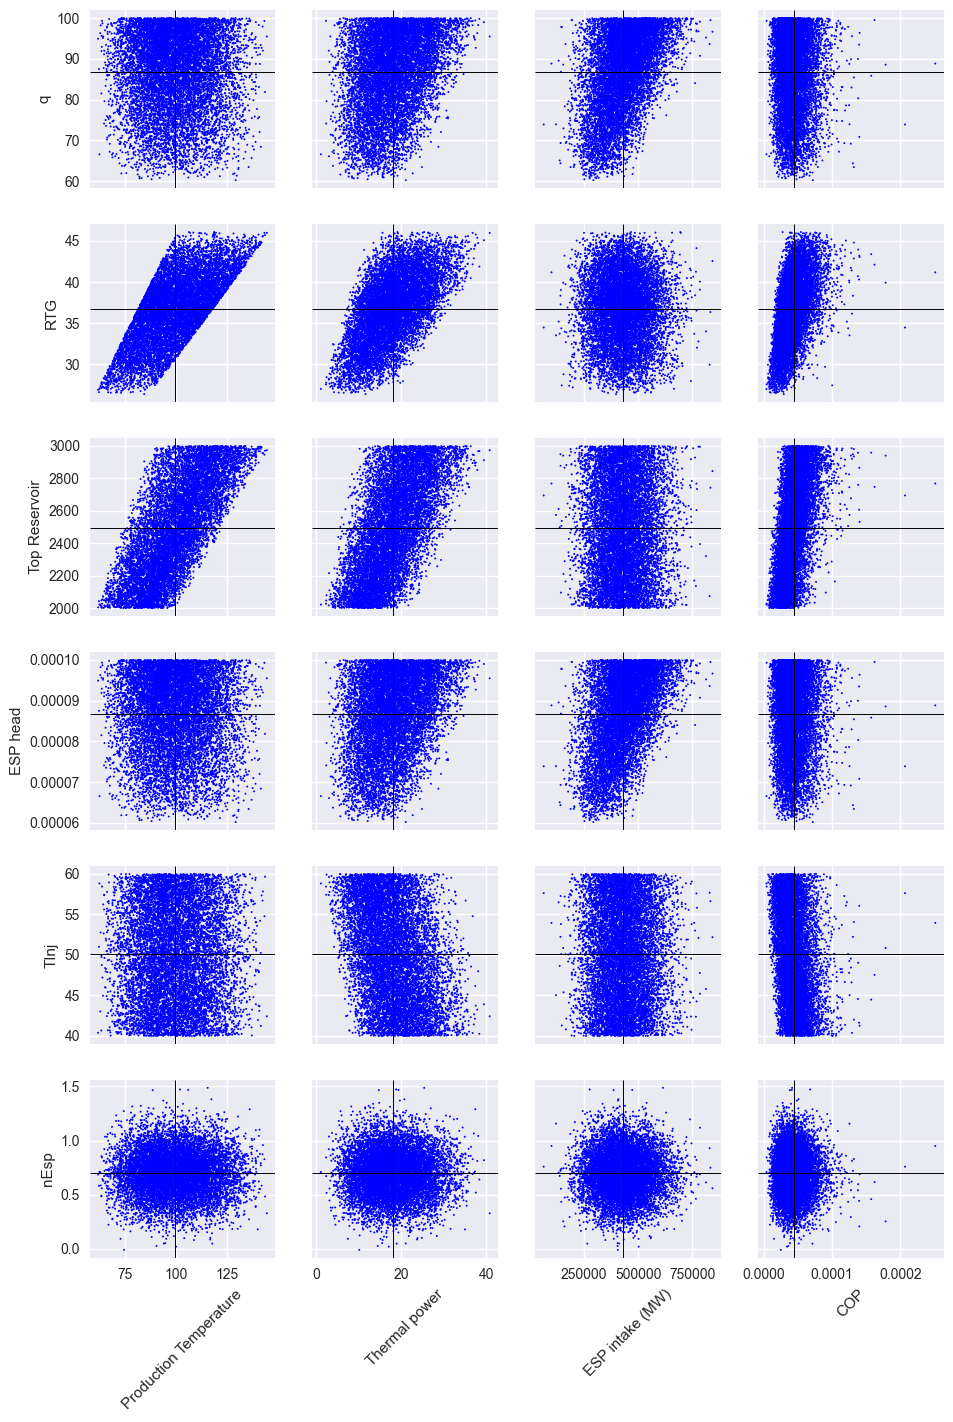

In [18]:
mysim.plot_pairplot(focus = False)

For a quantitative sensitivity of the results to the parameters, let's look at a matrix of correlation coefficients. We can choose between the Spearman or Pearson correlation coefficient.

In [19]:
spearmansr, pearsonr, __, __ = mysim.correlate()

print('Spearman correlation coefficients')
display(spearmansr)

print('Pearson correlation coefficients')
display(pearsonr)

Spearman correlation coefficients


,Production Temperature,Thermal power,ESP intake (MW),COP
q,-0.01,0.31,0.47,0.00
RTG,0.69,0.60,-0.01,0.51
Top Reservoir,0.72,0.63,0.01,0.52
ESP head,-0.01,0.31,0.47,0.00
TInj,-0.00,-0.35,-0.01,-0.28
nEsp,-0.01,-0.00,-0.00,-0.00


Pearson correlation coefficients


,Production Temperature,Thermal power,ESP intake (MW),COP
q,-0.01,0.30,0.46,0.00
RTG,0.66,0.58,-0.02,0.53
Top Reservoir,0.72,0.63,0.01,0.56
ESP head,-0.01,0.30,0.46,0.00
TInj,-0.01,-0.34,-0.01,-0.31
nEsp,-0.01,-0.00,-0.00,-0.00


Another helpful plot for a sensitivity analysis are Tornado plots.
Please note: The sensitivities shown in a Tornado plot depend on the *uncertainty of the parameter*. If a highly influential parameter has only small uncertainty, its corresponding bar in the tornado plot will be *small*.

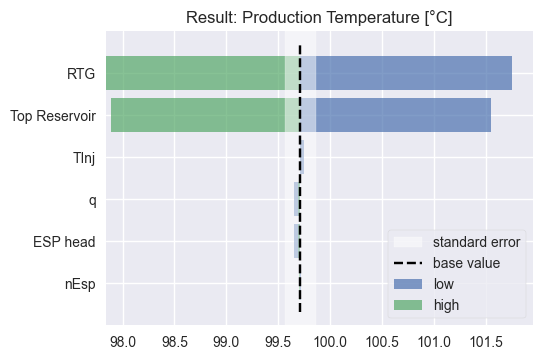

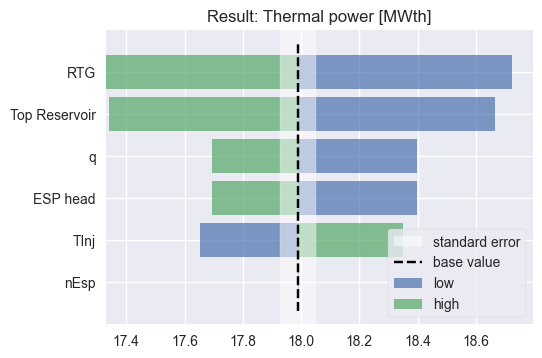

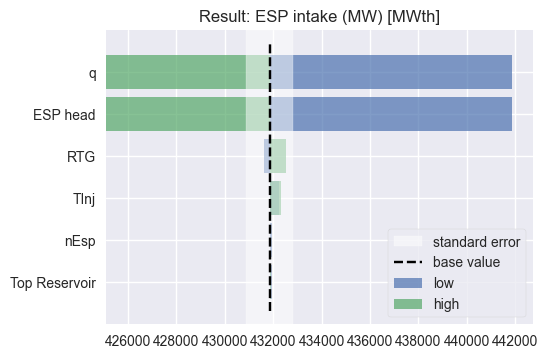

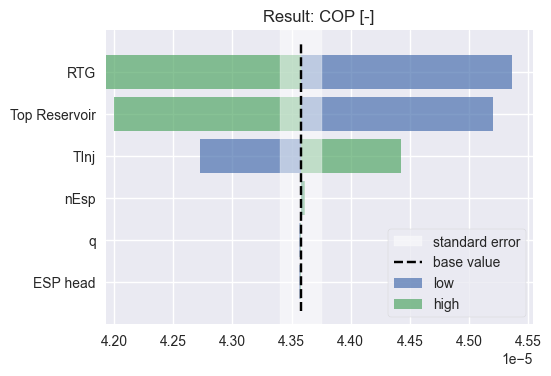

In [20]:
mysim.plot_tornado()